#Mounting Google Drive

In [1]:
####### Mouting Drive #######
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


#Unzip all Images

In [2]:
!unzip "/content/drive/MyDrive/Brain_Tumor/Brain_Tumor_Dataset.zip"

Archive:  /content/drive/MyDrive/Brain_Tumor/Brain_Tumor_Dataset.zip
   creating: Brain_Tumor_Dataset/
   creating: Brain_Tumor_Dataset/Data/
   creating: Brain_Tumor_Dataset/Data/no_tumor/
  inflating: Brain_Tumor_Dataset/Data/no_tumor/non_tumor (1).jpg  
  inflating: Brain_Tumor_Dataset/Data/no_tumor/non_tumor (10).jpg  
  inflating: Brain_Tumor_Dataset/Data/no_tumor/non_tumor (100).jpg  
  inflating: Brain_Tumor_Dataset/Data/no_tumor/non_tumor (101).jpg  
  inflating: Brain_Tumor_Dataset/Data/no_tumor/non_tumor (102).jpg  
  inflating: Brain_Tumor_Dataset/Data/no_tumor/non_tumor (103).jpg  
  inflating: Brain_Tumor_Dataset/Data/no_tumor/non_tumor (104).jpg  
  inflating: Brain_Tumor_Dataset/Data/no_tumor/non_tumor (105).jpg  
  inflating: Brain_Tumor_Dataset/Data/no_tumor/non_tumor (106).jpg  
  inflating: Brain_Tumor_Dataset/Data/no_tumor/non_tumor (107).jpg  
  inflating: Brain_Tumor_Dataset/Data/no_tumor/non_tumor (108).jpg  
  inflating: Brain_Tumor_Dataset/Data/no_tumor/non_tum

#PIP install Randomly Splitted

In [3]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#All Libraries

In [4]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import splitfolders
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import img_to_array
import os
#import matplotlib.pyplot as plt

#Input Image Dimention

In [5]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

#Splitted train & Test samples

In [6]:
splitfolders.ratio("/content/Brain_Tumor_Dataset/Data", output="/content/Brain_Tumor_Dataset/train_test_split",
    seed=42, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 3090 files [00:00, 4586.33 files/s]


#Applying Principle Component Analysis (PCA)

In [7]:
def apply_pca_to_images(image_directory, image_size, num_components):
    image_files = glob(image_directory + '/*/*.jpg')
    images = []
    labels = []

    for image_file in image_files:
        img = image.load_img(image_file, target_size=image_size)
        img_array = img_to_array(img)
        img_array = img_array.reshape(-1)
        images.append(img_array)
        labels.append(os.path.basename(os.path.dirname(image_file)))

    images = np.array(images)
    labels = np.array(labels)

    pca = PCA(n_components=num_components)
    pca_images = pca.fit_transform(images)

    return pca_images, labels, pca

#Training and Testing Path

In [8]:
num_components = 300  # Adjust the number of PCA components to your needs

train_path = '/content/Brain_Tumor_Dataset/train_test_split/train'
valid_path = '/content/Brain_Tumor_Dataset/train_test_split/val'

pca_train_images, train_labels, pca = apply_pca_to_images(train_path, IMAGE_SIZE, num_components)
pca_valid_images, valid_labels, _ = apply_pca_to_images(valid_path, IMAGE_SIZE, num_components)

#Principle Component Analysis (PCA_Visualization)

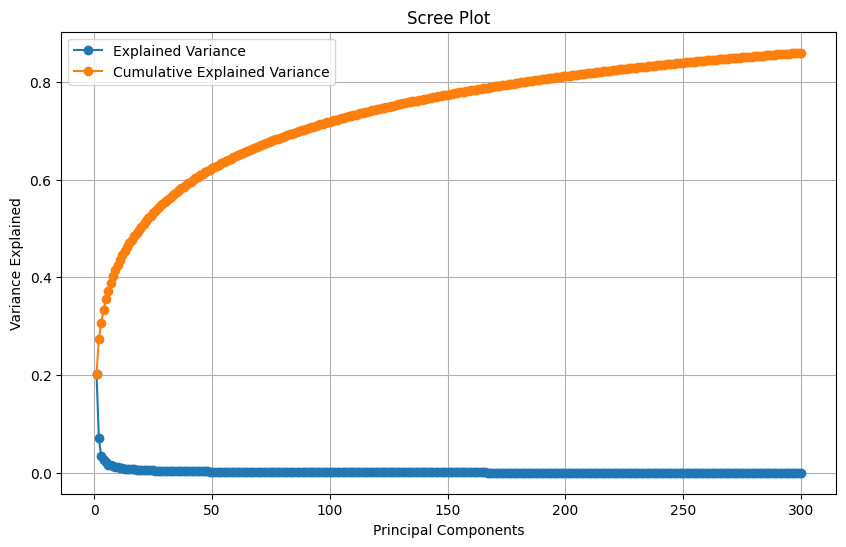

In [9]:
import matplotlib.pyplot as plt

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_components + 1), explained_variance, marker='o', label='Explained Variance')
plt.plot(range(1, num_components + 1), cumulative_explained_variance, marker='o', label='Cumulative Explained Variance')

plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.legend()
plt.grid()
plt.show()

In [10]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [11]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [12]:
# useful for getting number of classes
folders = glob('/content/Brain_Tumor_Dataset/train_test_split/train/*')

In [13]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [14]:
prediction = Dense(len(folders), activation='sigmoid')(x)

# create a model object
inceptionV3_model = Model(inputs=inception.input, outputs=prediction)

In [15]:
#################### Add Prefix of inceptionV3_ on each layer of the Pre-Defined Model ###################################
import tensorflow as tf

def add_prefix(model, prefix: str, custom_objects=None):

    
    config = model.get_config()
    old_to_new = {}
    new_to_old = {}
    
    for layer in config['layers']:
        new_name = prefix + layer['name']
        old_to_new[layer['name']], new_to_old[new_name] = new_name, layer['name']
        layer['name'] = new_name
        layer['config']['name'] = new_name

        if len(layer['inbound_nodes']) > 0:
            for in_node in layer['inbound_nodes'][0]:
                in_node[0] = old_to_new[in_node[0]]
    
    for input_layer in config['input_layers']:
        input_layer[0] = old_to_new[input_layer[0]]
    
    for output_layer in config['output_layers']:
        output_layer[0] = old_to_new[output_layer[0]]
    
    config['name'] = prefix + config['name']
    new_model = tf.keras.Model().from_config(config, custom_objects)
    
    for layer in new_model.layers:
        layer.set_weights(model.get_layer(new_to_old[layer.name]).get_weights())
    
    return new_model

inceptionV3_model_renamed = add_prefix(inceptionV3_model, 'inceptionV3_')

# Check name of a layer as an example
print("Layer #2 name [before => after]:", inceptionV3_model.layers[1].name, "=>", inceptionV3_model_renamed.layers[1].name)

# Make sure weights are loaded correctly
for l1, l2 in zip(inceptionV3_model.layers, inceptionV3_model_renamed.layers):
    np.testing.assert_equal(l1.get_weights(), l2.get_weights())


Layer #2 name [before => after]: conv2d => inceptionV3_conv2d


#InceptionV3 Model

In [16]:
# view the structure of the model
inceptionV3_model_renamed.summary()

Model: "inceptionV3_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inceptionV3_input_1 (InputLaye  [(None, 224, 224, 3  0          []                               
 r)                             )]                                                                
                                                                                                  
 inceptionV3_conv2d (Conv2D)    (None, 111, 111, 32  864         ['inceptionV3_input_1[0][0]']    
                                )                                                                 
                                                                                                  
 inceptionV3_batch_normalizatio  (None, 111, 111, 32  96         ['inceptionV3_conv2d[0][0]']     
 n (BatchNormalization)         )                                                 

In [17]:
# tell the model what cost and optimization method to use
inceptionV3_model_renamed.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [18]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

#Training & Testing Directory

In [19]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/Brain_Tumor_Dataset/train_test_split/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')


Found 2472 images belonging to 2 classes.


In [20]:
test_set = test_datagen.flow_from_directory('/content/Brain_Tumor_Dataset/train_test_split/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 618 images belonging to 2 classes.


In [21]:
# fit the model
# Run the cell. It will take some time to execute
r = inceptionV3_model_renamed.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-21-17ea1e830907>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = inceptionV3_model_renamed.fit_generator(


Epoch 1/15
78/78 [==============================] - 57s 532ms/step - loss: 0.7177 - accuracy: 0.9086 - val_loss: 0.1409 - val_accuracy: 0.9628
Epoch 2/15
78/78 [==============================] - 39s 499ms/step - loss: 0.1835 - accuracy: 0.9587 - val_loss: 0.3625 - val_accuracy: 0.9094
Epoch 3/15
78/78 [==============================] - 40s 512ms/step - loss: 0.2981 - accuracy: 0.9494 - val_loss: 0.1771 - val_accuracy: 0.9709
Epoch 4/15
78/78 [==============================] - 40s 514ms/step - loss: 0.1298 - accuracy: 0.9717 - val_loss: 0.0669 - val_accuracy: 0.9854
Epoch 5/15
78/78 [==============================] - 39s 495ms/step - loss: 0.0707 - accuracy: 0.9862 - val_loss: 0.1498 - val_accuracy: 0.9676
Epoch 6/15
78/78 [==============================] - 38s 489ms/step - loss: 0.0878 - accuracy: 0.9834 - val_loss: 0.0970 - val_accuracy: 0.9806
Epoch 7/15
78/78 [==============================] - 39s 504ms/step - loss: 0.0438 - accuracy: 0.9899 - val_loss: 0.1024 - val_accuracy: 0.9676

#Computational Time

In [44]:
import time

In [45]:
# Prepare data generator for validation dataset
valid_datagen = ImageDataGenerator(rescale = 1./255)
valid_set = valid_datagen.flow_from_directory(valid_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 618 images belonging to 2 classes.


In [47]:
start_time = time.time()

# Predict results on the validation dataset
predictions = inceptionV3_model_renamed.predict(valid_set)

end_time = time.time()

# Calculate the time taken
time_taken = end_time - start_time
print("Time taken for prediction: {:.4f} seconds".format(time_taken))

20/20 [==============================] - 3s 145ms/step
Time taken for prediction: 3.2202 seconds


In [23]:
import keras

################# Saving the Trained Model of inceptionV3 ###############
directory_path =  "/content/Brain_Tumor_Dataset/train_test_split"
model_path = "{}/inceptionV3.h5".format(directory_path)
print("Saving inceptionV3 Model for Later Use..")
inceptionV3_model_renamed.save(model_path)
print("inceptionV3 Model Saved.")


################### Loading Stored inceptionV3 Model #########################
# directory_path = "/content/drive/MyDrive/Colab Notebooks/Auto-Encoder-BONE/Bone/Mura_data/mura_data"
# model_path = "{}/inceptionV3.h5".format(directory_path)
# inceptionV3_model_renamed = keras.models.load_model(model_path)


Saving inceptionV3 Model for Later Use..
inceptionV3 Model Saved.


#Visualization for training and Testing loss

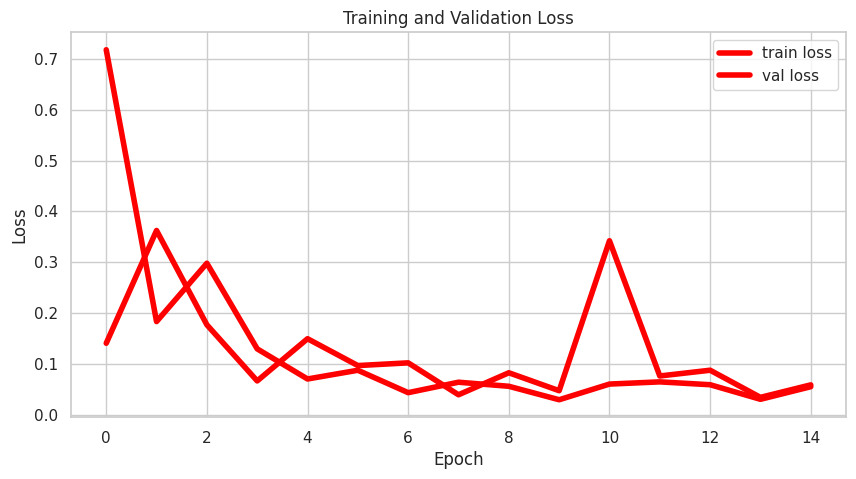

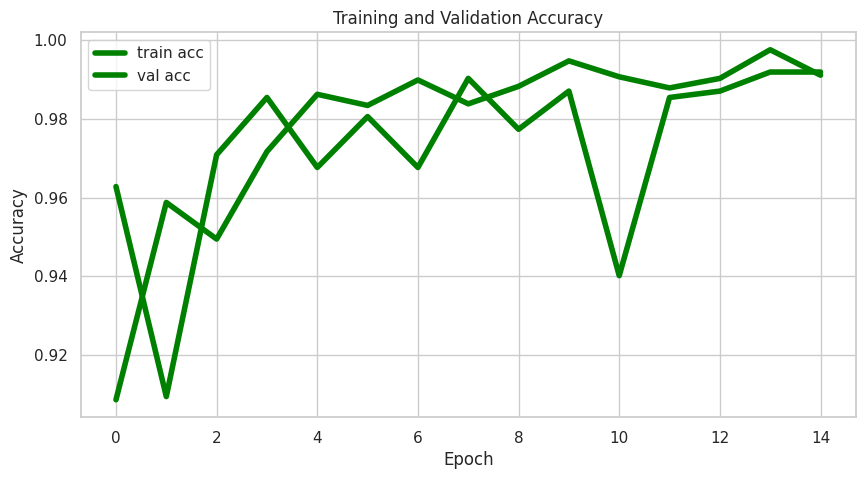

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style and color palette
sns.set(style="whitegrid")
sns.set_palette("husl")

# plot the loss
plt.figure(figsize=(10, 5))
sns.lineplot(data=r.history['loss'], label='train loss', color='red', linewidth=4)
sns.lineplot(data=r.history['val_loss'], label='val loss', color='red', linewidth=4)
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('LossVal_loss')
plt.show()

# plot the accuracy
plt.figure(figsize=(10, 5))
sns.lineplot(data=r.history['accuracy'], label='train acc', color='green', linewidth=4)
sns.lineplot(data=r.history['val_accuracy'], label='val acc', color='green', linewidth=4)
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('AccVal_acc')
plt.show()

#Visualization for Confusion matrix

In [53]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors

In [54]:
############ Finding the Prediction on Test Images ###############


actual_label_array = np.zeros((test_set.n), dtype=np.float32)
predicted_output_array = np.zeros((test_set.n), dtype=np.float32)

total_test_batches = len(test_set)

lower_index = 0

for i in range(total_test_batches):
  tmp_set = test_set.next()
  out_put = inceptionV3_model_renamed.predict( tmp_set[0] )
  upper_index = lower_index + out_put.shape[0]
  print("Processing Batch Number: ", i )
  # print(lower_index, upper_index, out_put.shape) 
  predicted_output_array[ lower_index : upper_index ] = np.argmax(out_put , axis=1)  
  actual_label_array[ lower_index : upper_index ] = np.argmax(tmp_set[1] , axis=1) 
  lower_index = upper_index
     

print( "Actual Test Labels: ", actual_label_array )
print( "Predicted Test Labels: ",  predicted_output_array )

1/1 [==============================] - 0s 55ms/step
Processing Batch Number:  0
1/1 [==============================] - 0s 45ms/step
Processing Batch Number:  1
1/1 [==============================] - 0s 55ms/step
Processing Batch Number:  2
1/1 [==============================] - 0s 52ms/step
Processing Batch Number:  3
1/1 [==============================] - 0s 45ms/step
Processing Batch Number:  4
1/1 [==============================] - 0s 45ms/step
Processing Batch Number:  5
1/1 [==============================] - 0s 49ms/step
Processing Batch Number:  6
1/1 [==============================] - 0s 49ms/step
Processing Batch Number:  7
1/1 [==============================] - 0s 50ms/step
Processing Batch Number:  8
1/1 [==============================] - 0s 34ms/step
Processing Batch Number:  9
1/1 [==============================] - 0s 35ms/step
Processing Batch Number:  10
1/1 [==============================] - 0s 36ms/step
Processing Batch Number:  11
1/1 [==============================] -

In [55]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        custom_cmap = mcolors.LinearSegmentedColormap.from_list("blue_purple", ["purple", "blue"])
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap=custom_cmap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

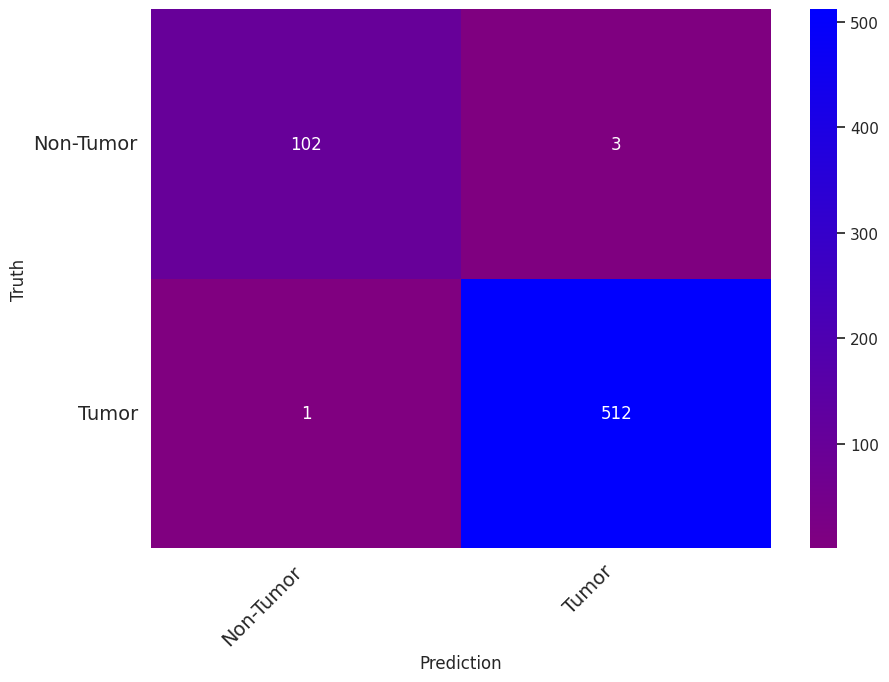

In [56]:
truth =actual_label_array
prediction = predicted_output_array
cm = confusion_matrix(truth,prediction)
print_confusion_matrix(cm,["Non-Tumor","Tumor"])

#Accuracy

In [57]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
pre = precision_recall_fscore_support (actual_label_array, predicted_output_array, average='micro')

print("Showing Precision: ")
print(precision_score(actual_label_array, predicted_output_array, average="macro"))
print("Showing Recall: ")
print(recall_score(actual_label_array, predicted_output_array, average="macro"))    
print("Showing F1 Score : ")
print(f1_score(actual_label_array, predicted_output_array, average="macro"))


Showing Precision: 
0.9922330097087378
Showing Recall: 
0.98473962684489
Showing F1 Score : 
0.9884390900927865


#Visualization ROC Curve

20/20 [==============================] - 3s 137ms/step


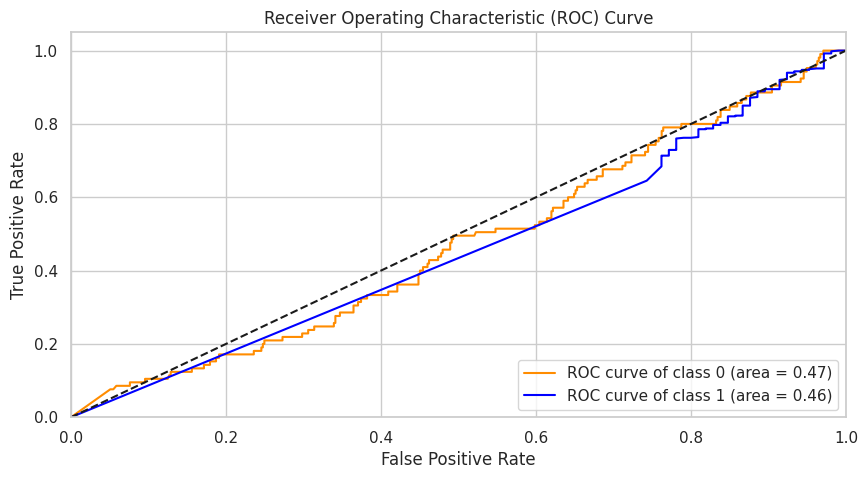

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert the labels to one-hot encoding
actual_one_hot = np.eye(len(np.unique(actual_label_array)))[actual_label_array.astype(int)]
predicted_prob = inceptionV3_model_renamed.predict(test_set)

for i in range(2): # Assuming you have two classes: Non-Tumor and Tumor
    fpr[i], tpr[i], _ = roc_curve(actual_one_hot[:, i], predicted_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Configure plot and color
sns.set(style="whitegrid")
sns.set_palette("husl")

plt.figure(figsize=(10, 5))
colors = ['darkorange', 'blue']

# Plot the ROC curve
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#Explainable AI-SHAP

In [59]:
######### Installing SHAP ########################
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 12.2 MB/s eta 0:00:00


In [60]:
#Get example images for each class:
class_names = ['Non-Tumor', 'Tumor']

tmp_train_set = training_set.next()
x_train = tmp_train_set[0]
y_train = tmp_train_set[1]

tmp_test_set = test_set.next()
x_test = tmp_test_set[0]
y_test = tmp_test_set[1]

images_dict = dict()
for i, l in enumerate(y_train):
    tmp_label = l.argmax()
    if len(images_dict) == 2:
        break
    if tmp_label not in images_dict.keys():
        images_dict[tmp_label] = x_train[i]
images_dict = dict(sorted(images_dict.items()))

x_test_dict = dict()
for i, l in enumerate(y_test):
    tmp_label = l.argmax()
    if len(x_test_dict) == 2:
        break
    if tmp_label not in x_test_dict.keys():
        x_test_dict[tmp_label] = x_test[i]

x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)

predictions = inceptionV3_model_renamed.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)

print(predicted_class)

1/1 [==============================] - 1s 1s/step
[0 1]


In [61]:
#Define the plot function for actual and predicted classes:
def plot_actual_predicted(images, pred_classes):
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))
    axes = axes.flatten()

    ax = axes[0]
    dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
    ax.set_title("Base reference")
    ax.set_axis_off()
    ax.imshow(dummy_array, interpolation='nearest')

    for k, v in images.items():
        ax = axes[k + 1]
        ax.imshow(v, cmap=plt.cm.binary)
        ax.set_title(f"True: %s \nPredict: %s" % (class_names[k], class_names[pred_classes[k]]))
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [62]:
import shap

background = x_train[np.random.choice(x_train.shape[0], 2, replace=False)]

explainer = shap.GradientExplainer(inceptionV3_model_renamed, background)

shap_values = explainer.shap_values(x_test_each_class)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


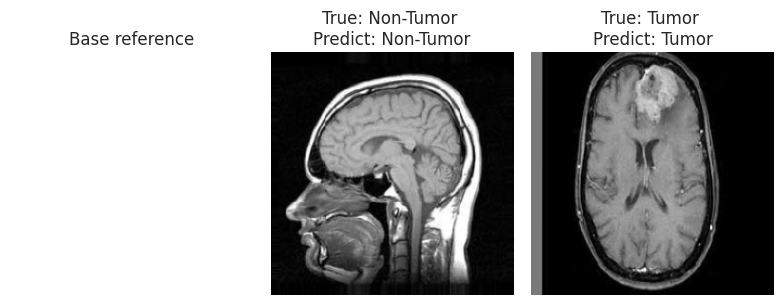

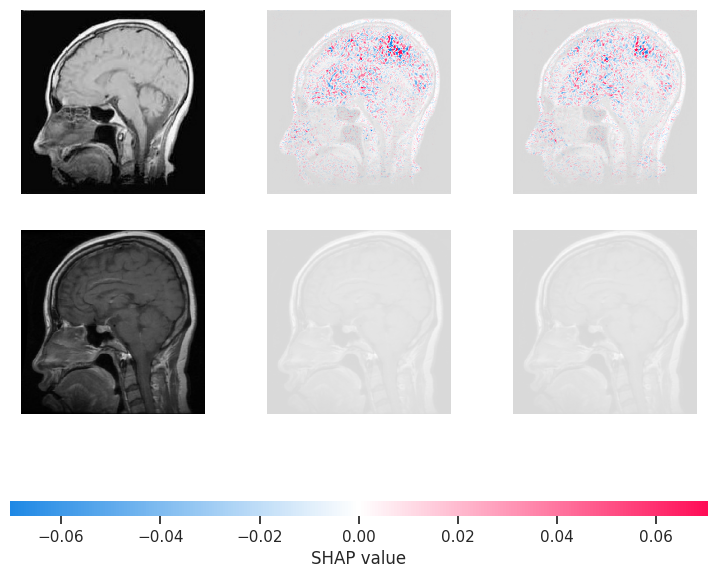

In [63]:
#Plot SHAP values:
plot_actual_predicted(images_dict, predicted_class)
print()
shap.image_plot(shap_values, x_test_each_class)

#Explainable AI-LIME

In [64]:
#Install the LIME library:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=aa7a78574adfd8d042aa9ee4348a37c4d0ab0777785d0a3410d9db018a351ded
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [65]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic

In [66]:
lime_explainer = lime_image.LimeImageExplainer()

In [68]:
def custom_predict_fn(images):
    return inceptionV3_model_renamed.predict(images)

In [69]:
def custom_segmentation_fn_wrapper(n_segments):
    def custom_segmentation_fn(image):
        return slic(image, n_segments=n_segments, compactness=30, sigma=3)
    return custom_segmentation_fn

In [70]:
num_samples = 1000  # number of perturbed samples to generate
num_superpixels = 50  # number of superpixels to use for segmentation

lime_explanations = []
for image in x_test_each_class:
    explanation = lime_explainer.explain_instance(image, custom_predict_fn, top_labels=2, hide_color=0, num_samples=num_samples, segmentation_fn=custom_segmentation_fn_wrapper(num_superpixels))
    lime_explanations.append(explanation)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


In [71]:
def plot_lime_explanations(images, explanations):
    fig, axes = plt.subplots(2, len(images), figsize=(10, 4))

    for i, (image, explanation) in enumerate(zip(images, explanations)):
        # Normalize the image to the range [0, 1]
        normalized_image = (image - image.min()) / (image.max() - image.min())

        # Plot the original image
        axes[0, i].imshow(normalized_image)
        axes[0, i].set_title(f"Image {i+1}")
        axes[0, i].axis('off')

        # Get the explanation mask for the predicted class
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

        # Normalize the temp values to the range [0, 1]
        temp = (temp - temp.min()) / (temp.max() - temp.min())

        # Plot the LIME explanation
        axes[1, i].imshow(mark_boundaries(temp / 2 + 0.5, mask))
        axes[1, i].set_title(f"LIME explanation")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

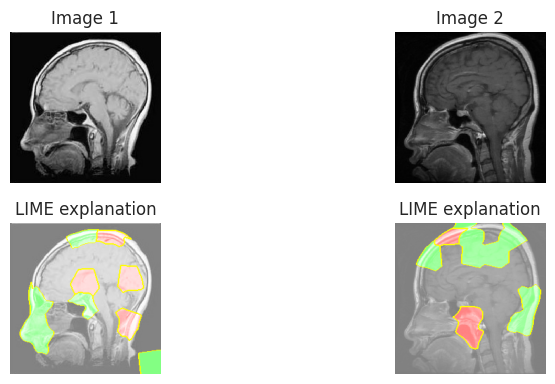

In [72]:
plot_lime_explanations(x_test_each_class, lime_explanations)

#Explainable AI- Grad-CAM (Gradient-weighted Class Activation Mapping)

In [73]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [74]:
def load_and_preprocess_image(image_path, image_size):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = tf.keras.applications.densenet.preprocess_input(x)
    return x

In [75]:
def get_model_layers(model):
    last_conv_layer = model.get_layer('inceptionV3_conv2d_93')
    output_layer = model.get_layer('dense')
    return last_conv_layer, output_layer

In [76]:
def generate_grad_cam_heatmap(img_path, model, last_conv_layer, output_layer):
    # Load and preprocess the image
    img = load_and_preprocess_image(img_path, model.input_shape[1:3])
    img = np.expand_dims(img, axis=0)

    # Get the predicted class index and output predictions
    preds = model.predict(img)
    class_index = np.argmax(preds[0])
    class_output = model.output[:, class_index]

    # Compute the gradient of the output layer with respect to the last convolutional layer
    grads = tf.keras.backend.gradients(class_output, last_conv_layer.output)[0]

    # Compute the global average pooling of the gradients
    pooled_grads = tf.keras.backend.mean(grads, axis=(0, 1, 2))

    # Create a function to compute the values of the last convolutional layer and pooled gradients
    iterate = tf.keras.backend.function([model.input], [last_conv_layer.output, pooled_grads, output_layer.output])
    conv_output, grad_values, predictions = iterate([img])

    # Compute the weighted combination of the last convolutional layer values with the pooled gradients
    weights = np.mean(grad_values, axis=0)
    cam = np.dot(conv_output[0], weights)

    # Reshape the heatmap and clip values below zero
    cam = cv2.resize(cam, model.input_shape[1:3])
    cam = np.maximum(cam, 0)

    # Normalize the heatmap
    heatmap = cam / np.max(cam)

    # Return the heatmap and predicted class index
    return heatmap, class_index

In [77]:
import cv2
import numpy as np

def display_grad_cam_heatmap(img_path, model, last_conv_layer_name, heatmap_path):
    # Load the model and get the last convolutional layer and output layer
    model = tf.keras.models.load_model(model)
    last_conv_layer, output_layer = get_model_layers(model)

    # Generate the Grad-CAM heatmap
    heatmap, class_index = generate_grad_cam_heatmap(img_path, model, last_conv_layer, output_layer)

    # Load the original image and preprocess it
    img = load_and_preprocess_image(img_path, model.input_shape[1:3])
    img = np.uint8(255 * img)

    # Resize the heatmap to the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert the heatmap to RGB format and overlay it on the original image
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Save the heatmap as a separate file
    cv2.imwrite(heatmap_path, heatmap)

    # Display the original image and the superimposed image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    plt.show()

In [78]:
import cv2
import matplotlib.pyplot as plt

def visualize_heatmap(img_path, heatmap_path):
    # Load the original image
    img = cv2.imread(img_path)

    # Load the heatmap
    heatmap = cv2.imread(heatmap_path)

    # Resize the heatmap to the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert the heatmap to grayscale
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)

    # Apply color map to the heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Add the heatmap to the original image
    overlaid_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Plot the original image and overlaid image with heatmap
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original Image')
    ax[1].imshow(cv2.cvtColor(overlaid_img, cv2.COLOR_BGR2RGB))
    ax[1].set_title('Overlaid Image with Heatmap')
    plt.show()

#Tumor Visualization

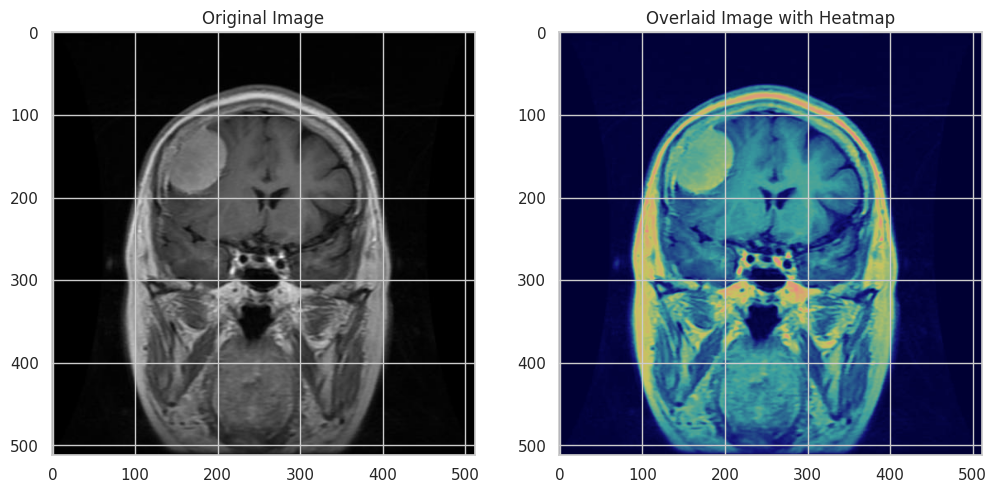

In [80]:
img_path = '/content/Brain_Tumor_Dataset/train_test_split/val/tumor/tumor (1005).jpg'
heatmap_path = '/content/Brain_Tumor_Dataset/train_test_split/val/tumor/tumor (1005).jpg'

visualize_heatmap(img_path, heatmap_path)

#Non_Tumor Visualization

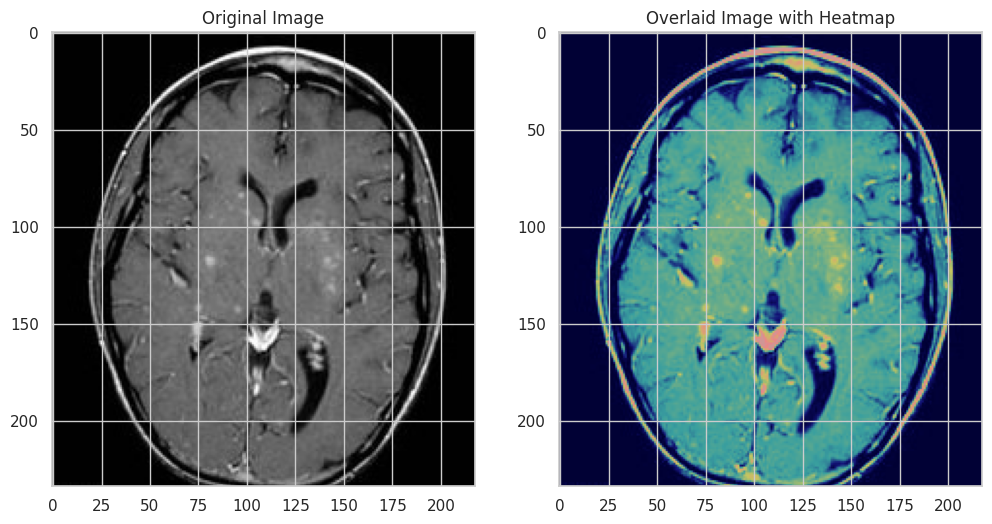

In [81]:
img_path = '/content/Brain_Tumor_Dataset/train_test_split/val/no_tumor/non_tumor (130).jpg'
heatmap_path = '/content/Brain_Tumor_Dataset/train_test_split/val/no_tumor/non_tumor (130).jpg'

visualize_heatmap(img_path, heatmap_path)